In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

%config InlineBackend.figure_format = 'retina'


In [ ]:
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix


In [ ]:
import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re
import seaborn as sns
os.environ['CUDA_VISIBLE-DEVICES']='0'
torch.cuda.is_available()

True

In [ ]:
files = zf.ZipFile("dataset-resized.zip",'r')
files.extractall()
files.close()

In [ ]:
os.listdir(os.path.join(os.getcwd(),"dataset-resized"))

['.DS_Store', 'trash', 'plastic', 'metal', 'paper', 'glass', 'cardboard']

In [ ]:
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    ## train indices
    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.5*n))

    ## temp
    remain = list(set(full_set)-set(train))

    ## separate remaining into validation and test
    random.seed(seed2)
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)

## gets file names for a particular type of trash, given indices
    ## input: waste category and indices
    ## output: file names 
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

## moves group of source files to another folder
    ## input: list of source files and destination folder
    ## no output
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)

In [ ]:

## paths will be train/cardboard, train/glass, etc...
subsets = ['train','valid']
waste_types = ['cardboard','glass','metal','paper','plastic','trash']

## create destination folders for data subset and waste type
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
if not os.path.exists(os.path.join('data','test')):
    os.makedirs(os.path.join('data','test'))
            
## move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('dataset-resized',waste_type)
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    
    ## move source files to train
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "data/train/"+waste_type
    move_files(train_source_files,train_dest)
    
    ## move source files to valid
    valid_names = get_names(waste_type,valid_ind)
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
    valid_dest = "data/valid/"+waste_type
    move_files(valid_source_files,valid_dest)
    
    ## move source files to test
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    ## I use data/test here because the images can be mixed up
    move_files(test_source_files,"data/test")

In [ ]:
## get a path to the folder with images
path = Path(os.getcwd())/"data"
path

PosixPath('/content/data')

In [ ]:
tfms = get_transforms(do_flip=True,flip_vert=True)
data = ImageDataBunch.from_folder(path,test="test",ds_tfms=tfms,bs=16)


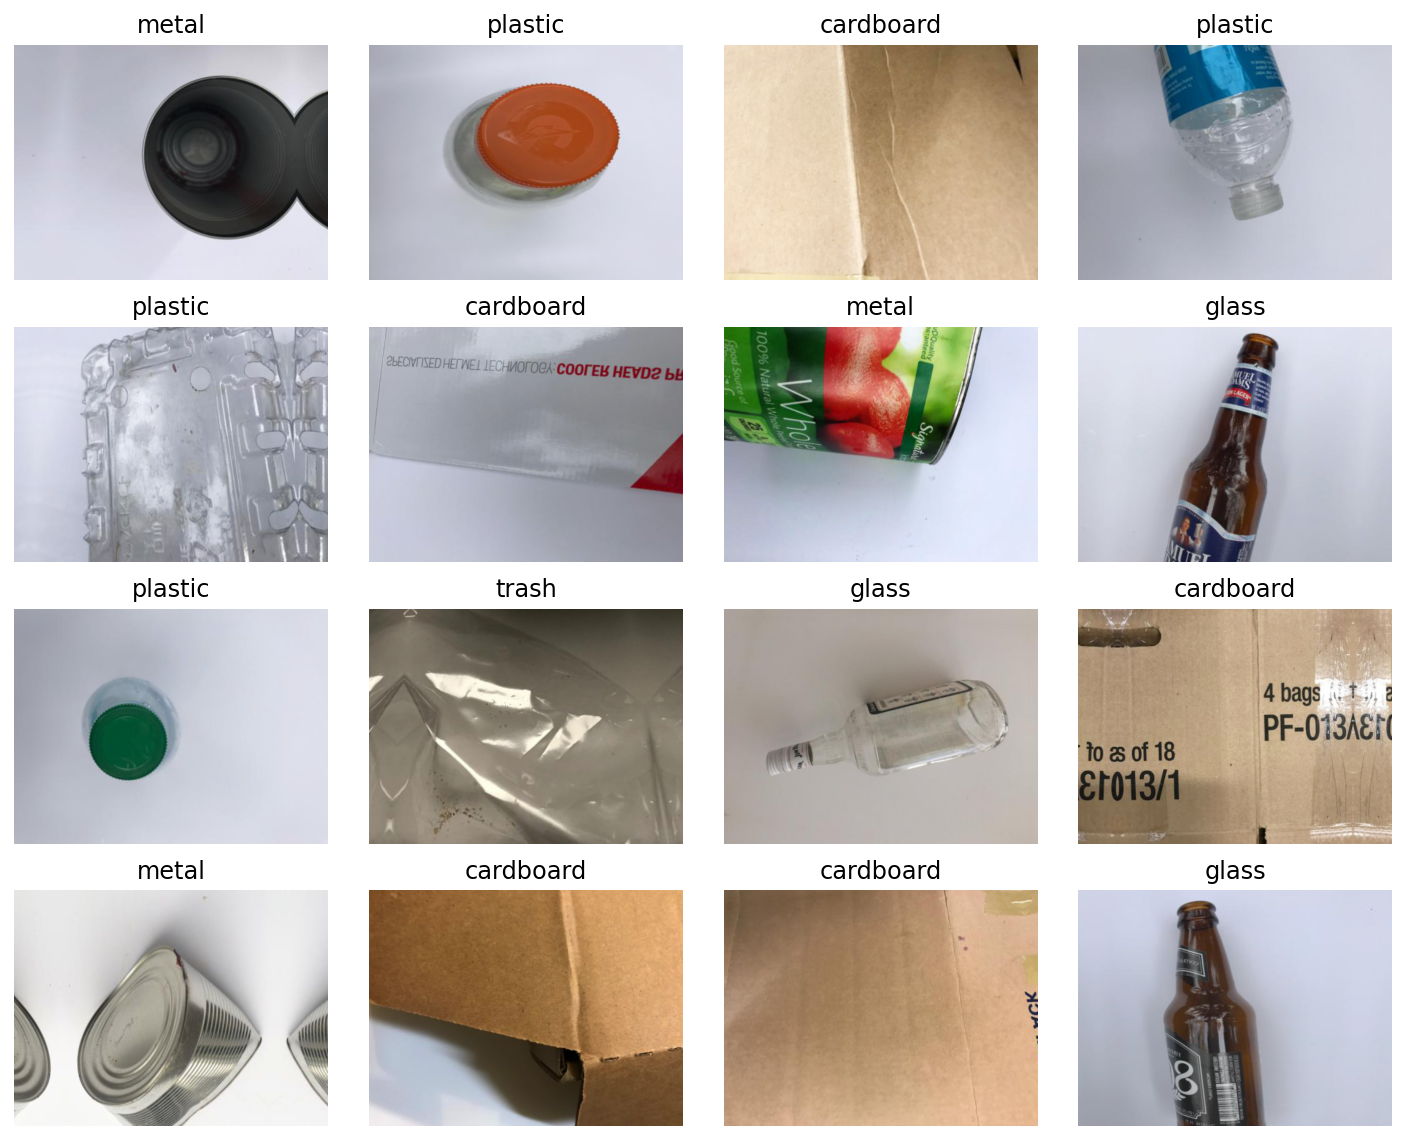

In [ ]:
data.show_batch(rows=4,figsize=(10,8))

In [ ]:
learn = create_cnn(data,models.resnet34,metrics=error_rate)


/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:109: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:

learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


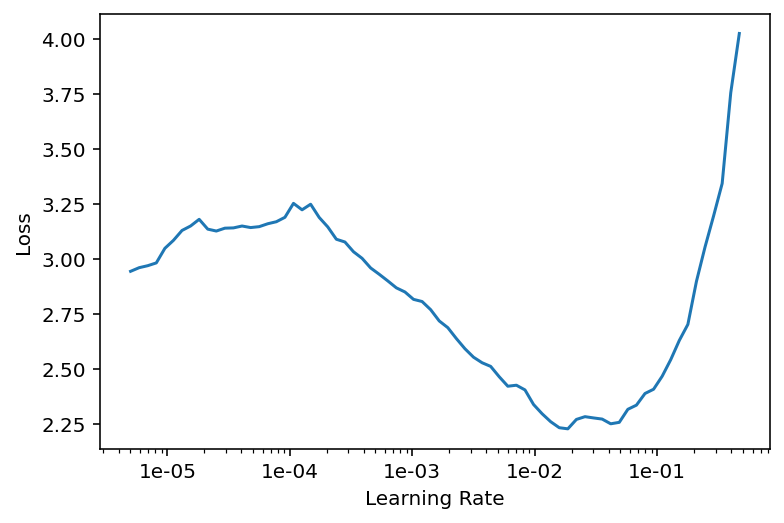

In [ ]:
learn.lr_find(start_lr=1e-6,end_lr=1e1)
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(20,max_lr=5.13e-03)

epoch,train_loss,valid_loss,error_rate,time
0,1.659261,0.695080,0.258730,00:54
1,1.170459,0.550386,0.163492,00:51
2,0.907211,0.590788,0.187302,00:52
3,0.912697,0.596052,0.206349,00:51
4,0.848304,0.708217,0.196825,00:51
5,0.817472,0.587868,0.179365,00:51
6,0.732829,0.631501,0.192063,00:51
7,0.742696,0.555349,0.152381,00:49
8,0.708704,0.506350,0.149206,00:51
9,0.651561,0.462706,0.138095,00:51


In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()


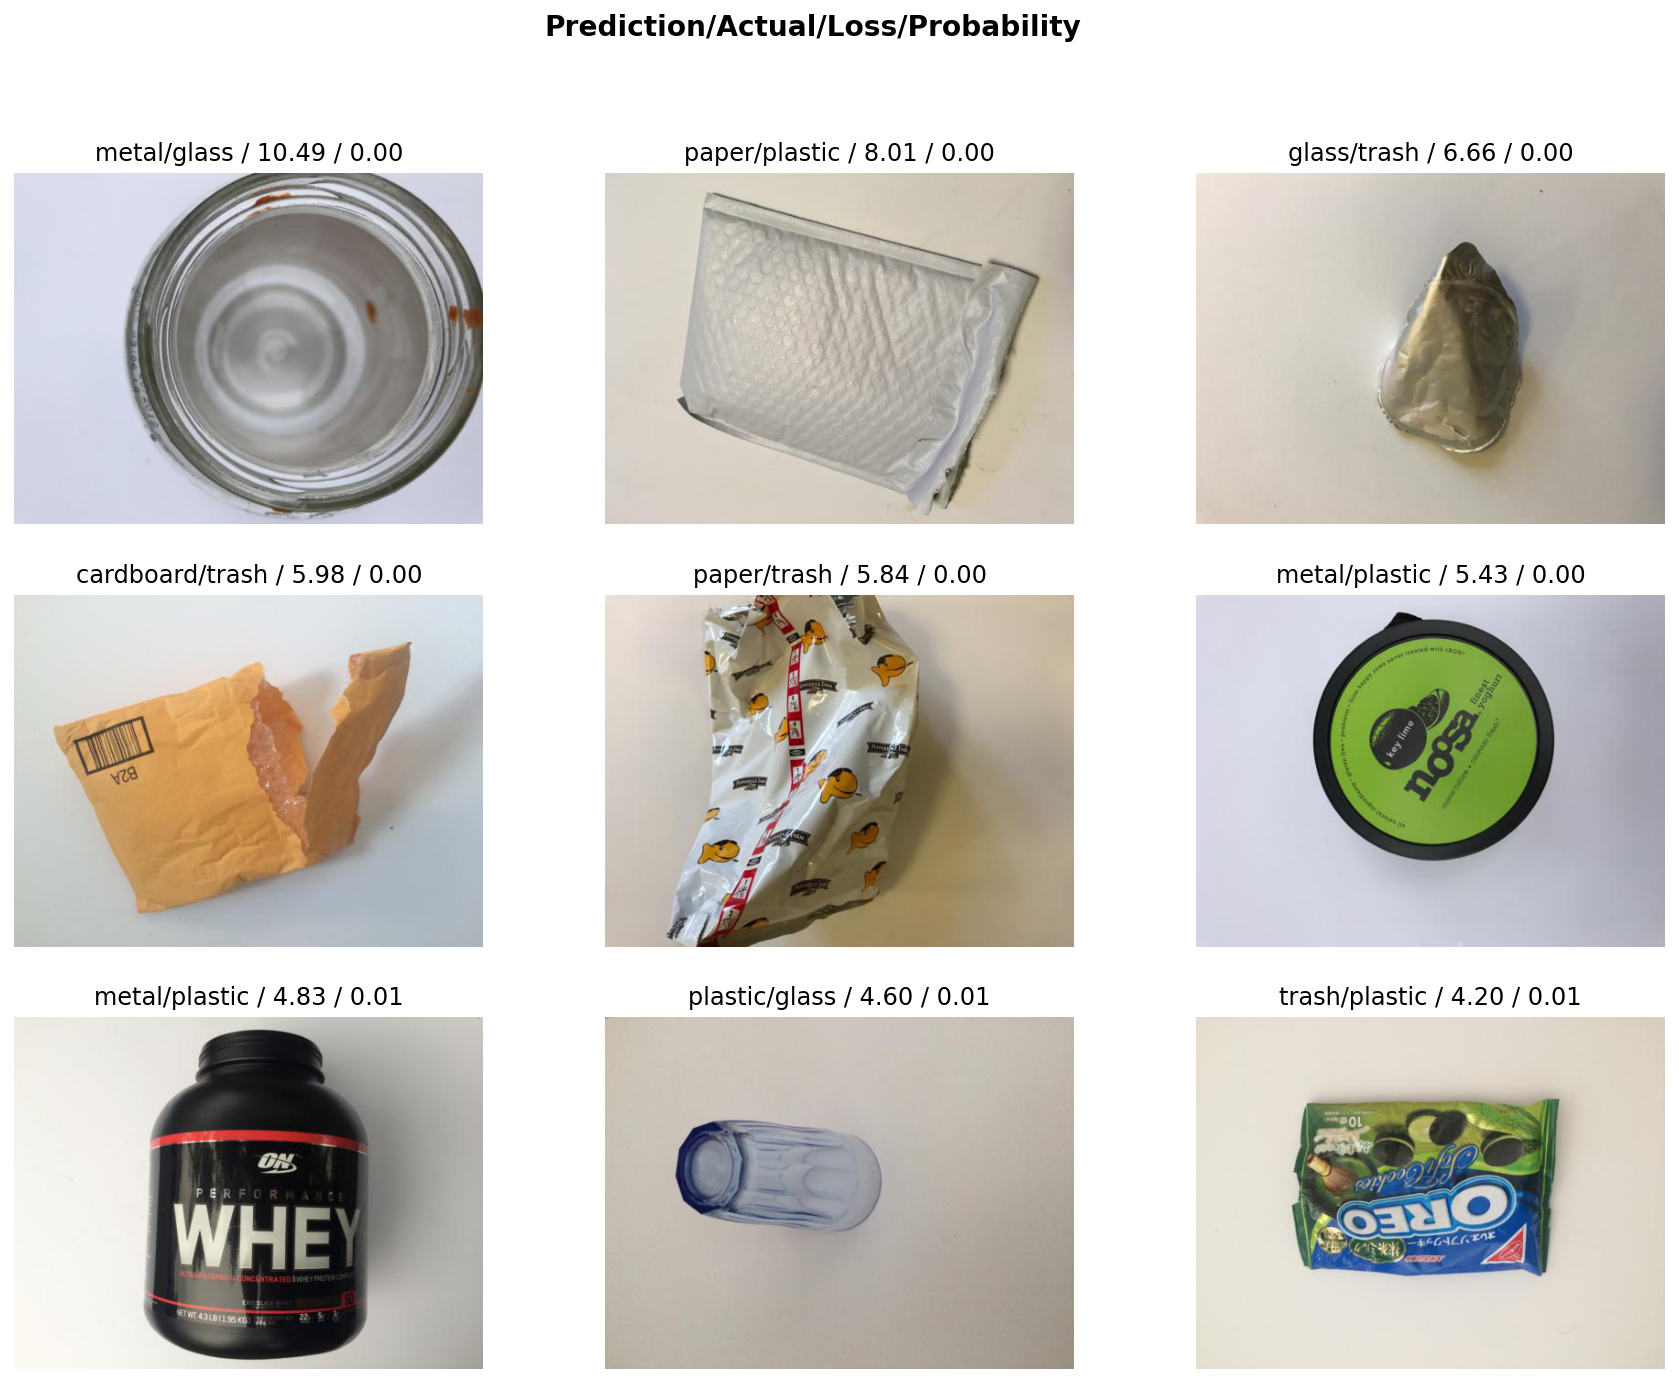

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))


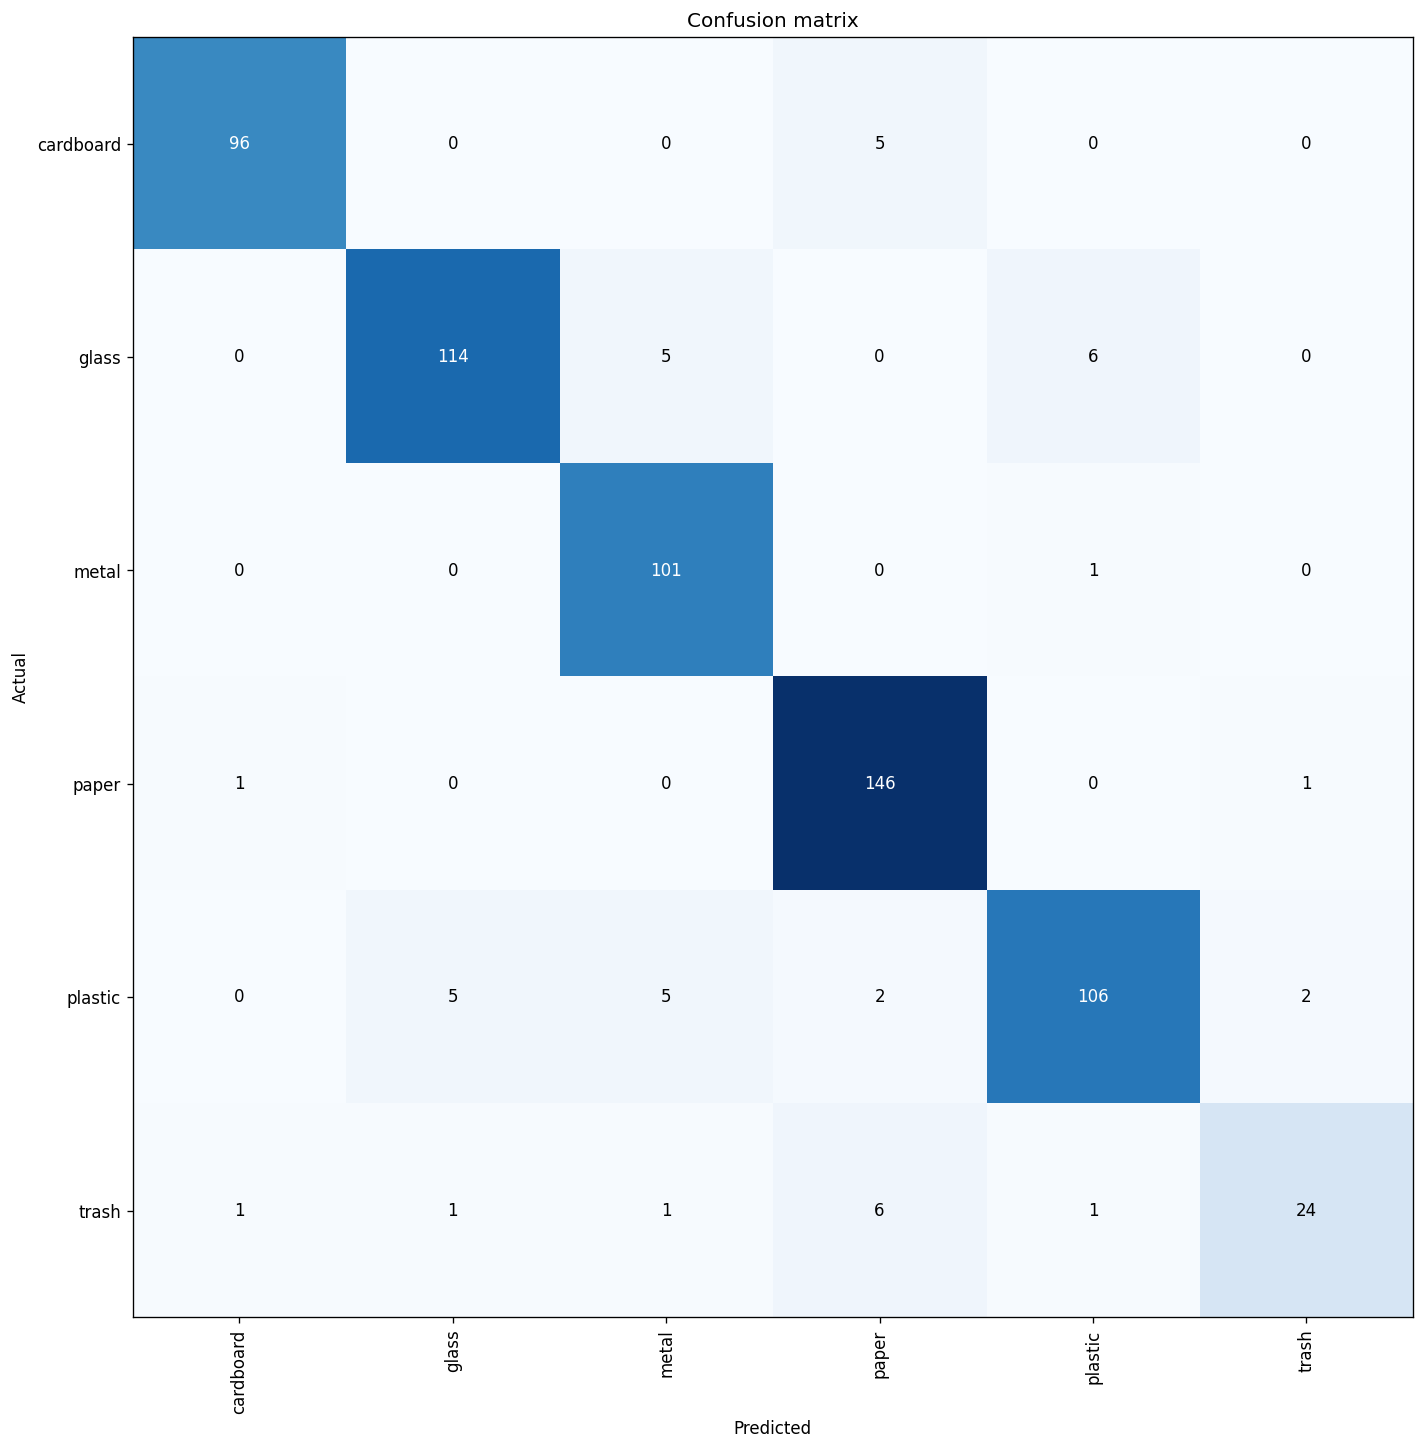

In [ ]:
doc(interp.plot_top_losses)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.most_confused(min_val=2)

[('glass', 'plastic', 6),
 ('trash', 'paper', 6),
 ('cardboard', 'paper', 5),
 ('glass', 'metal', 5),
 ('plastic', 'glass', 5),
 ('plastic', 'metal', 5),
 ('plastic', 'paper', 2),
 ('plastic', 'trash', 2)]

In [ ]:

preds = learn.get_preds(ds_type=DatasetType.Test)

In [ ]:

print(preds[0].shape)
preds[0]

torch.Size([635, 6])


tensor([[9.3152e-06, 9.9362e-01, 4.9652e-06, 8.2204e-05, 6.2690e-03, 1.1330e-05],
        [8.7027e-11, 9.9984e-01, 7.0421e-07, 1.0011e-08, 1.5659e-04, 5.6101e-10],
        [6.3063e-04, 6.9352e-07, 1.6021e-04, 9.9803e-01, 3.5897e-04, 8.1630e-04],
        ...,
        [1.1025e-05, 3.2750e-04, 1.2430e-07, 9.9966e-01, 4.8757e-06, 2.4782e-08],
        [3.2011e-06, 9.8171e-01, 1.6349e-05, 4.8579e-06, 1.8173e-02, 9.2950e-05],
        [4.1541e-05, 9.1091e-08, 9.9995e-01, 1.1129e-06, 3.9987e-06, 2.6775e-08]])

In [ ]:

data.classes


['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [ ]:
data.classes[1]

'glass'

In [ ]:

## saves the index (0 to 5) of most likely (max) predicted class for each image
max_idxs = np.asarray(np.argmax(preds[0],axis=1))

In [ ]:
yhat = []
for max_idx in max_idxs:
    yhat.append(data.classes[max_idx])

In [ ]:
yhat

['glass',
 'glass',
 'paper',
 'paper',
 'paper',
 'glass',
 'cardboard',
 'glass',
 'metal',
 'cardboard',
 'glass',
 'glass',
 'trash',
 'cardboard',
 'glass',
 'trash',
 'paper',
 'plastic',
 'paper',
 'metal',
 'cardboard',
 'metal',
 'paper',
 'plastic',
 'paper',
 'paper',
 'paper',
 'glass',
 'paper',
 'glass',
 'paper',
 'plastic',
 'paper',
 'cardboard',
 'plastic',
 'metal',
 'cardboard',
 'metal',
 'plastic',
 'glass',
 'paper',
 'glass',
 'paper',
 'paper',
 'paper',
 'glass',
 'paper',
 'metal',
 'plastic',
 'glass',
 'plastic',
 'metal',
 'paper',
 'metal',
 'metal',
 'paper',
 'paper',
 'metal',
 'plastic',
 'plastic',
 'paper',
 'cardboard',
 'paper',
 'cardboard',
 'paper',
 'cardboard',
 'paper',
 'cardboard',
 'metal',
 'trash',
 'glass',
 'cardboard',
 'metal',
 'paper',
 'paper',
 'cardboard',
 'plastic',
 'cardboard',
 'glass',
 'paper',
 'metal',
 'plastic',
 'paper',
 'paper',
 'paper',
 'cardboard',
 'paper',
 'plastic',
 'glass',
 'cardboard',
 'paper',
 'plas

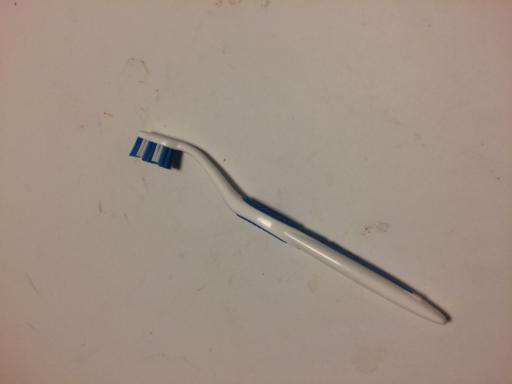

In [ ]:
learn.data.test_ds[100][0]


In [ ]:
y = []

## convert POSIX paths to string first
for label_path in data.test_ds.items:
    string_of_path = str(label_path)
    string_of_path = string_of_path[15:]
    y.append(str(string_of_path))
       
   
## then extract waste type from file path
pattern = re.compile("([a-z]+)[0-9]+")
for i in range(len(y)):
    y[i] = pattern.search(y[i]).group(1)
  
 

In [ ]:

## predicted values
print(yhat[0:5])
## actual values
print(y[0:5])

['glass', 'glass', 'paper', 'paper', 'paper']
['glass', 'glass', 'paper', 'paper', 'paper']


In [ ]:
cm = confusion_matrix(y,yhat)
print(cm)

[[ 94   0   0   6   1   0]
 [  0 116   8   0   2   0]
 [  0   5  94   0   2   2]
 [  0   0   0 147   0   2]
 [  0   8   0   1 110   2]
 [  1   1   0   3   4  26]]


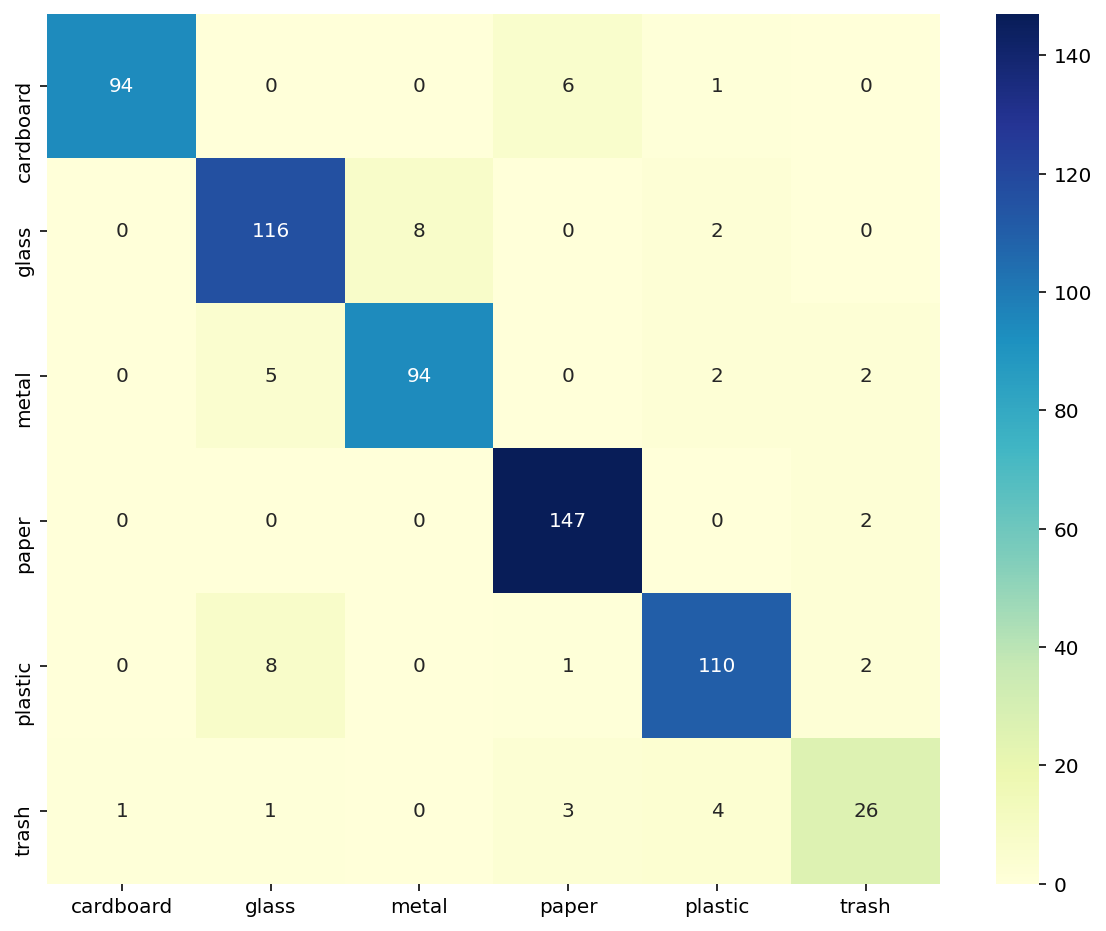

In [ ]:
df_cm = pd.DataFrame(cm,waste_types,waste_types)

plt.figure(figsize=(10,8))
sns.heatmap(df_cm,annot=True,fmt="d",cmap="YlGnBu")

In [ ]:


correct = 0

for r in range(len(cm)):
    for c in range(len(cm)):
        if (r==c):
            correct += cm[r,c]

In [ ]:

accuracy = correct/sum(sum(cm))
accuracy

0.9244094488188976

In [ ]:
learn.export('/content/exported.pkl')

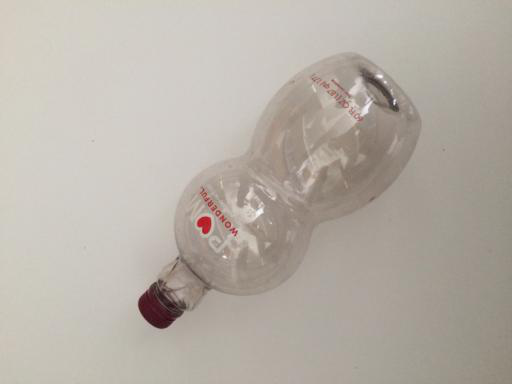

In [ ]:
#defaults.device = torch.device('cpu')
img = open_image(path/'/content/plastic8.jpg')
img

In [ ]:

pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category tensor(4)

In [ ]:
outputs

tensor([6.0012e-02, 3.6591e-04, 2.3850e-01, 6.9925e-01, 9.2862e-04, 9.4356e-04])